## Project 4: Collaborative Filtering via Gaussian Mixtures

### 2. K-Means

For this part of the project you will compare clustering obtained via K-means to the (soft) clustering induced by EM. In order to do so, our K-means algorithm will differ a bit from the one you learned. Here, the means are estimated exactly as before but the algorithm returns additional information. More specifically, we use the resulting clusters of points to estimate a Gaussian model for each cluster. Thus, our K-means algorithm actually returns a mixture model where the means of the component Gaussians are the $K$ centroids computed by the K-means algorithm. This is to make it such that we can now directly plot and compare solutions returned by the two algorithms as if they were both estimating mixtures.

Final Cost: 1035.499826539466


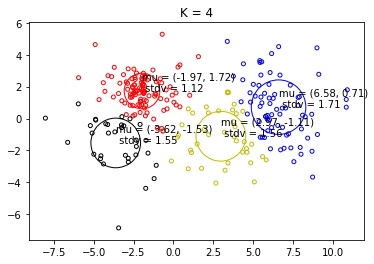

In [62]:
import numpy as np
from typing import List, Dict, Tuple, Optional
from netflix import kmeans, common
from netflix.common import GaussianMixture

# Read a 2D toy dataset 
X : np.ndarray = np.loadtxt('./netflix/toy_data.txt')

# Setup the number of clusters
clusters = 4

# Initialize the K-means algorithm using the implementation in "kmeans.py"
# It returns the initialized gaussian mixture
init_results : Tuple[GaussianMixture, np.ndarray] = common.init(X, K = clusters, seed = 4)

# Run the actual KMeans algorithm
algo_results : Tuple[GaussianMixture, np.ndarray, float] = kmeans.run(X, init_results[0], init_results[1]) 

# Print the cost
cost : float = algo_results[2]
print("Final Cost:", cost)

# Plot the solution
common.plot(X, algo_results[0], algo_results[1], title = f"K = {clusters}")

### 3. Expectation-maximization Algorithm

#### E-Step

In [21]:
from typing import Tuple
import numpy as np
from nptyping import NDArray, Float, Shape

# ==============================
# E-STEP
# ==============================

def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment
    """

    # Get the means, variances and the mixing proportions out of the mixture
    # "NamedTuple"
    mu, var, p = mixture

    # Important dimensions
    n, d = X.shape
    K, _ = mu.shape
    
    # Probability Density Function of a Gaussian
    def N(
        x : NDArray[Shape["1, 2"], Float], 
        mu_j : NDArray[Shape["1, 2"], Float], 
        var_j : float

    ) -> float:
        """
        MLE (Maximum likelihood estimate) for a Gaussian model. It consists of the 
        probability density function for a gaussian random variable, or in other
        words, the product of multiple multivariate gaussian's.

        NOTE: Obtained by calculating the log of the joint probability density function
        (A very simple expression) and then just canceling out the log by getting the 
        exponential of the final value.
        
        Got equation from: https://learning.edx.org/course/course-v1:MITx+6.86x+2T2022/block-v1:MITx+6.86x+2T2022+type@sequential+block@lec15_gm/block-v1:MITx+6.86x+2T2022+type@vertical+block@lec15_gm-tab10

        Args:
            x (np.ndarray): Sample point "xi"
            mu_j (np.ndarray): Mean of mixture "j"
            var_j (float): Variance of mixture "j"

        Returns:
            float: Likelihood
        """
        # NOTE: We use the square of "np.linalg.norm" to get the sum of the squares of each
        # component of each data point in "X". This means that if a data point in X is [1, 2]
        # and the mean is [1, 1], np.linalg.norm(x - mu, axis=1)**2 will be equal to:
        # (1 - 1)^2 + (2 - 1)^2 = 1
        
        log_likelihood = - ((n)/2) * np.log(2 * np.pi * var_j)
        log_likelihood -= (1/(2*var_j)) * np.linalg.norm(x - mu_j)**2
        return np.exp(log_likelihood)


    # Initialize the likelihood array
    # Shape: (n, K)
    pj_times_likelihood : NDArray[Shape[n, K], Float] = np.zeros((n, K))

    # Go through each sample "xi" and each gaussian distribution "j"
    for i, xi in enumerate(X):
        for j in range(K):

            # Get the probability that a data point "xi" was generated by each of the
            # "j" mixtures (likelihood). Each row consists of a new data point entry and each column
            # consists of the probability that the "ith" data point was generated by the
            # "jth" cluster
            pj_times_likelihood[i, j] = p[j] * N(xi, mu[j, :], var[j])

    # Probability that each "xi" was generated by any of the mixtures
    # Shape: (n, 1)
    p_xi_given_theta : NDArray[Shape[n, 1], Float] = np.sum(pj_times_likelihood, axis=1, keepdims=True)

    print(pj_times_likelihood, p_xi_given_theta)

    # Get the posterior probabilities 
    # Shape: (n, K)
    posterior : NDArray[Shape[n, K], Float] = pj_times_likelihood / p_xi_given_theta

    # Get the log-likelihood
    # Basically takes the total probability of each sample (xi) being generated by any of the
    # mixture and sums them all. Given that the source probabilities have a shape of
    # (n,), the final product will be a scalar
    # Shape: Scalar
    log_likelihood : float = np.sum(np.log(p_xi_given_theta))

    return (posterior, log_likelihood)

# Test the function
out = estep(X, init_results[0])
# print(out)

[[8.77723814e-254 3.07203015e-234 2.17073656e-250]
 [8.52823196e-254 1.87953042e-234 2.14020885e-250]
 [8.54574538e-254 2.09036392e-234 2.22768554e-250]
 [8.46974462e-254 2.37688137e-234 2.29848131e-250]
 [8.72966989e-254 2.70502965e-234 2.28944787e-250]
 [8.70134020e-254 2.58300552e-234 2.28466001e-250]
 [8.74754901e-254 2.81715657e-234 2.12255169e-250]
 [8.51382897e-254 2.47238586e-234 2.30662418e-250]
 [8.80908735e-254 2.76986927e-234 2.21505964e-250]
 [8.73243132e-254 2.31461062e-234 2.16102213e-250]
 [8.70740243e-254 2.24921763e-234 2.13335658e-250]
 [8.69505556e-254 2.36529032e-234 2.24523022e-250]
 [8.45085078e-254 4.11757057e-234 2.10625376e-250]
 [8.70049354e-254 2.60283735e-234 2.28765603e-250]
 [8.78018823e-254 3.07621235e-234 2.28299518e-250]
 [8.78407901e-254 2.81360356e-234 2.15953994e-250]
 [8.66282832e-254 2.11213871e-234 2.13627873e-250]
 [8.35009413e-254 1.59696682e-234 2.01758781e-250]
 [8.81147977e-254 2.94157584e-234 2.24004214e-250]
 [8.74162932e-254 2.41703811e-2

In [30]:
def log_gaussian(x: np.ndarray, mean: np.ndarray, var: float) -> float:
    """Computes the log probablity of vector x under a normal distribution
    Args:
        x: (d, ) array holding the vector's coordinates
        mean: (d, ) mean of the gaussian
        var: variance of the gaussian
    Returns:
        float: the log probability
    """
    d = len(x)
    log_prob = -d / 2.0 * np.log(2 * np.pi * var)
    log_prob -= 0.5 * ((x - mean) ** 2).sum() / var
    return log_prob

def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment
    """

    # Instructor's solution:
    n, _ = X.shape
    K, _ = mixture.mu.shape
    post = np.zeros((n, K))

    ll = 0
    for i in range(n):
        mask = (X[i, :] != 0)
        for j in range(K):
            log_likelihood = log_gaussian(X[i, mask], mixture.mu[j, mask],
                                          mixture.var[j])
            post[i, j] = np.log(mixture.p[j] + 1e-16) + log_likelihood
        total = np.log(np.sum(np.exp(post[i, :])))
        post[i, :] = post[i, :] - total
        ll += total

    return np.exp(post), ll

#### M-Step

In [31]:
# ==============================
# M-STEP
# ==============================

def mstep(X: np.ndarray, post: np.ndarray) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
    """

    # NOTE: After maximizing the proxy function used to replace the log likelihood (We cannot
    # maximize the actual log likelihood cause it would be very difficult, since it consists
    # of one giant multiplication), we get expressions to calculate a new version of the means,
    # variances, and ratio for each mixture component (p). We calculate each new component in 
    # this step.

    # Get important dimensions from the data
    n, d = X.shape
    _, K = post.shape

    # Sample-wise probability total
    # Shape: (K, 1)
    n_hat = sum_pj_given_i = np.sum(post, axis=0, keepdims=True).T

    # =====================
    # MEANS

    # Mean Estimate
    # Shape: (K, d)
    mu_hat = np.dot(post.T, X) / sum_pj_given_i

    # =====================
    # VARIANCES

    # Variance Estimate
    var_hat = np.zeros((K,))
    for j, mu_hat_j in enumerate(mu_hat):
        
        # Norm of the difference between the samples (xi) and the estimated means
        # Shape: (n, 1)
        norm = np.linalg.norm(X - mu_hat_j, axis=1, keepdims=True)**2

        # Posterior probabilities for the "jth" gaussian.
        post_j = np.reshape(post[:, j], (-1, 1))

        # Weighted and normalized sum of the norms
        # Shape: sum((n, 1) * (n, 1)) / scalar = scalar
        var_hat[j] = (post_j.T @ norm) / (d * sum_pj_given_i[j])

    # =====================
    # PROPORTIONS

    p_hat = (1/n) * sum_pj_given_i

    # =====================
    # OUTPUT

    return GaussianMixture(mu_hat, var_hat, p_hat)

# Test the function
mixture = mstep(X, out[0])
print(mixture)

GaussianMixture(mu=array([[-2.76129963,  0.93440581],
       [ 1.064496  ,  0.550068  ],
       [-2.86761652,  0.6693919 ]]), var=array([ 6.06948221, 10.9245949 ,  5.97952028]), p=array([[2.35374802e-20],
       [1.00000000e+00],
       [6.50153333e-17]]))


#### Run

In [34]:
# ==============================
# RUN
# ==============================

def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model

    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples

    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """

    # Initial values for "old_log_likelihood" and "new_log_likelihood".
    # NOTE: An initial value of none, assures us that the algorithm will always run 
    # its first two iterations
    old_log_likelihood = None
    new_log_likelihood = None
    
    # Get the initial values for the mixture
    mu, var, p = mixture

    # Criteria for stopping:
    # The convergence criteria that you should use is that the improvement in 
    # the log-likelihood is less than or equal to 10^-6 multiplied by the absolute value 
    # of the new log-likelihood
    while (old_log_likelihood is None) or ((new_log_likelihood - old_log_likelihood) > 1e-6 * np.abs(new_log_likelihood)):

        # Store the last log likelihood
        old_log_likelihood = new_log_likelihood

        # E-step
        post, new_log_likelihood = estep(X, mixture)

        # M-step
        mixture = mstep(X, post)

    # Return the final values
    return (mixture, post, new_log_likelihood)


------

### 4. Comparing K-means and EM

Generate analogous plots to K-means using your EM implementation. Note that the EM algorithm can also get stuck in a locally optimal solution. For each value of $K$, please run the EM algorithm with seeds $0, 1, 2, 3, 4$ and select the solution that achieves the highest log-likelihood. Compare the K-means and mixture solutions for $K = [1,2,3,4]$. Ask yourself when, how, and why they differ.

#### Reporting Log-likelihood values

Report the maximum likelihood for each $K$ using seeds $0, 1, 2, 3, 4$

Final Log Likelihood: -1175.7146850058014


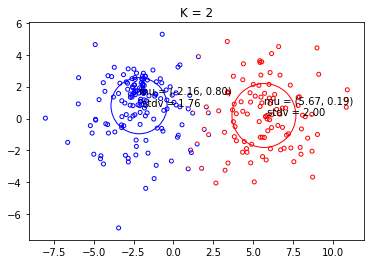

In [65]:
# Parameters
clusters = 2
seed_no = 0

# Initialize the clusters
init_results : Tuple[GaussianMixture, np.ndarray] = common.init(X, K = clusters, seed = seed_no)

# Run the actual KMeans algorithm
algo_results : Tuple[GaussianMixture, np.ndarray, float] = run(X, init_results[0], init_results[1]) 

# Print the log likelihood
log_likelihood : float = algo_results[2]
print("Final Log Likelihood:", log_likelihood)

# Plot the solution
common.plot(X, algo_results[0], algo_results[1], title = f"K = {clusters}")

# K = 1
# - All log likelihoods are the same: -1307.223431760

# K = 2
# - Seed 0: -1175.7146850058014
# - Seed 1: -1175.714863727956
# - Seed 2: -1175.7146293666792
# - Seed 3: -1175.7146708423356
# - Seed 4: -1175.7146484290488

# K = 3
# - Seed 0: -1138.8908996872672
# - Seed 1: -1138.8915268582045
# - Seed 2: -1138.8913232476136
# - Seed 3: -1138.8909601749288
# - Seed 4: -1138.891055801127

# K = 4
# - Seed 0: -1138.6978681199807
# - Seed 1: -1138.891045633598
# - Seed 2: -1138.6035882684873
# - Seed 3: -1138.60157891682
# - Seed 4: -1138.6011756994853

------

### 5. Bayesian Information Criterion

So far we have simply set the number of mixture components $K$ but this is also a parameter that we must estimate from data. How does the log-likelihood of the data vary as a function of $K$ assuming we avoid locally optimal solutions?

To compensate, we need a selection criterion that penalizes the number of parameters used in the model. The Bayesian information criterion (BIC) is a criterion for model selection. It captures the tradeoff between the log-likelihood of the data, and the number of parameters that the model uses. The BIC of a model $M$ is defined as:

$$ \displaystyle  \text {BIC}(M) = l - \frac{1}{2}p \log n $$
 		 	 	 	 
where $l$ is the log-likelihood of the data under the current model (highest log-likelihood we can achieve by adjusting the parameters in the model), $p$ is the number of free parameters, and $n$ is the number of data points. This score rewards a larger log-likelihood, but penalizes the number of parameters used to train the model. In a situation where we wish to select models, we want a model with the the highest BIC.

#### Implementing the Bayesian Information Criterion

In [63]:
def bic(X: np.ndarray, mixture: GaussianMixture, log_likelihood: float) -> float:
    """Computes the Bayesian Information Criterion for a
    mixture of gaussians

    Args:
        X: (n, d) array holding the data
        mixture: a mixture of spherical gaussian
        log_likelihood: the log-likelihood of the data

    Returns:
        float: the BIC for this mixture
    """

    # BIC(M) = l - (1/2) * p * log(n)
    # l: Log likelihood of the data for the current model
    # p: Number of free parameters
    # n: Number of data points

    # Get all the quantities out of the mixture
    mean, var, prob = mixture

    # Getting all the parameters for the BIC equation
    l = log_likelihood
    K, d = mean.shape
    n, _ = X.shape

    # Total parameters in EM algorithm:
    # - "K" means with "d" dimensions
    # - "K" variances (Since the covariance matrix consists of a diagonal matrix)
    # - "K-1" probabilities (We dont need all "K" probabilities because the last 
    #   one can be calculated using "1 - (all other probabilities)")
    p = (K * d) + K + (K - 1)

    # Return BIC equation
    return l - (1/2) * p * np.log(n)


994.0888696554993


#### Picking the best K

In [83]:
# Parameters
clusters = 3
seed_no = 1

# Initialize the clusters
init_results : Tuple[GaussianMixture, np.ndarray] = common.init(X, K = clusters, seed = seed_no)

# Run the actual KMeans algorithm
algo_results : Tuple[GaussianMixture, np.ndarray, float] = run(X, init_results[0], init_results[1]) 

# Print the log likelihood
log_likelihood : float = algo_results[2]
print("Final Log Likelihood:", log_likelihood)

# Print BIC score
print("BIC:", bic(X, algo_results[0], algo_results[2]))

# BIC Scores:
# The optimal K and BIC will be the K with the smallest BIC
# - K = 1: -1315.5056231368872
# - K = 2: -1195.039976940474
# - K = 3: -1169.2595619064468 (Optimal)
# - K = 4: -1180.1088250039477

Final Log Likelihood: -1138.8915268582045
BIC: -1169.2595619064468


### 7. Implement EM for matrix completion

#### Implementing E-Step (2)

In [ ]:
def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component

    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        mixture: the current gaussian mixture

    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment

    """
    raise NotImplementedError